In [149]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
from scipy.stats import genpareto
import pytensor.tensor as pt

In [150]:
# Download S&P 500 data
data = yf.download("^GSPC", start="1986-01-01", progress=False)['Close']
returns = data.pct_change().dropna()
losses = -returns[returns < 0].dropna()   

/tmp/ipykernel_3995/1054586192.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("^GSPC", start="1986-01-01", progress=False)['Close']


In [151]:
if isinstance(losses, pd.Series):
    losses_array = losses.values
else:
    losses_array = np.array(losses)

# Use the array for analysis
losses = losses_array

In [152]:
print("="*50)
print("DATA SUMMARY")
print("="*50)
print(f"Total losses: {len(losses)}")
print(f"Minimum loss: {np.min(losses):.6f}")
print(f"Maximum loss: {np.max(losses):.6f}")
print(f"Mean loss: {np.mean(losses):.6f}")
print(f"Std loss: {np.std(losses):.6f}")
print(f"95th percentile: {np.percentile(losses, 95):.6f}")
print(f"99th percentile: {np.percentile(losses, 99):.6f}")
print(f"99.5th percentile: {np.percentile(losses, 99.5):.6f}")
print(f"99.9th percentile: {np.percentile(losses, 99.9):.6f}")


DATA SUMMARY
Total losses: 4620
Minimum loss: 0.000003
Maximum loss: 0.204669
Mean loss: 0.007842
Std loss: 0.009378
95th percentile: 0.023800
99th percentile: 0.042388
99.5th percentile: 0.051888
99.9th percentile: 0.088535


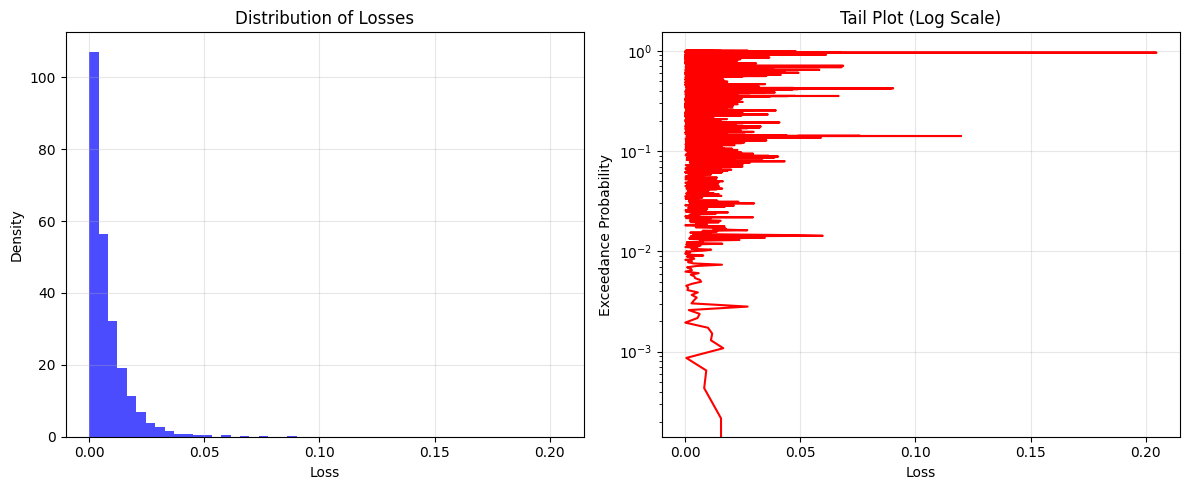

In [153]:
# Plot the distribution of losses
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(losses, bins=50, density=True, alpha=0.7, color='blue')
plt.xlabel('Loss')
plt.ylabel('Density')
plt.title('Distribution of Losses')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
sorted_losses = np.sort(losses)
ecdf = np.arange(1, len(sorted_losses) + 1) / len(sorted_losses)
plt.plot(sorted_losses, 1 - ecdf, 'r-')
plt.xlabel('Loss')
plt.ylabel('Exceedance Probability')
plt.yscale('log')
plt.title('Tail Plot (Log Scale)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


THRESHOLD SELECTION ANALYSIS
90th percentile (0.017897): 462 exceedances (10.0000%)
92.5th percentile (0.020367): 347 exceedances (7.5108%)
95th percentile (0.023800): 231 exceedances (5.0000%)
96.5th percentile (0.027097): 162 exceedances (3.5065%)
97.1th percentile (0.029293): 134 exceedances (2.9004%)
98th percentile (0.032361): 93 exceedances (2.0130%)
99th percentile (0.042388): 47 exceedances (1.0173%)
99.5th percentile (0.051888): 24 exceedances (0.5195%)
99.9th percentile (0.088535): 5 exceedances (0.1082%)

Selected threshold (97.5th percentile): 0.029293
Number of exceedances: 134
Exceedance rate: 2.9004%


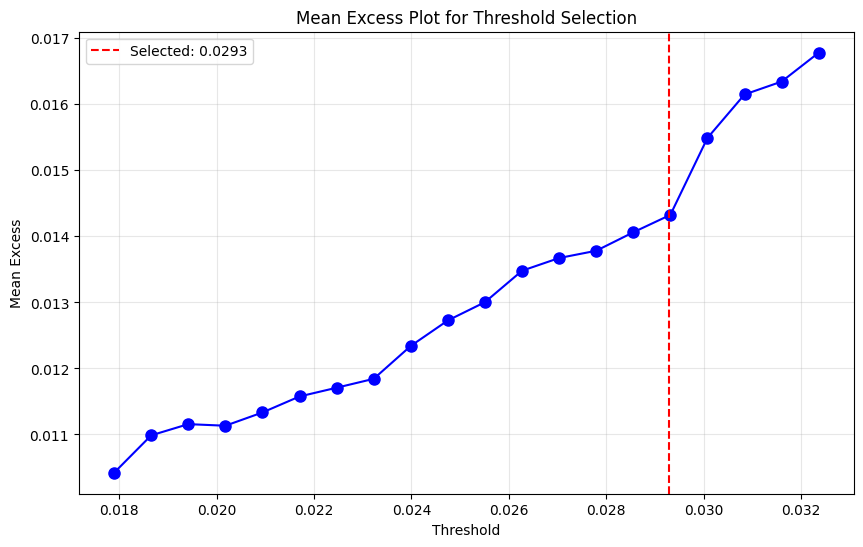

In [170]:
# Step 1: Let's try multiple thresholds to see which gives reasonable exceedance rates
print("\n" + "="*50)
print("THRESHOLD SELECTION ANALYSIS")
print("="*50)

# Try thresholds from 90th to 99.9th percentile
percentiles = [90, 92.5, 95, 96.5, 97.1, 98, 99, 99.5, 99.9]
for p in percentiles:
    threshold = np.percentile(losses, p)
    exceedances = losses[losses > threshold] - threshold
    rate = len(exceedances) / len(losses)
    print(f"{p}th percentile ({threshold:.6f}): {len(exceedances)} exceedances ({rate:.4%})")

# Based on typical POT methodology, let's choose threshold at 97.1th percentile
threshold = np.percentile(losses, 97.1)
exceedances = losses[losses > threshold] - threshold
print(f"\nSelected threshold (97.5th percentile): {threshold:.6f}")
print(f"Number of exceedances: {len(exceedances)}")
print(f"Exceedance rate: {len(exceedances)/len(losses):.4%}")

# Plot mean excess for threshold selection
def mean_excess_plot(data, thresholds):
    """Plot mean excess for given thresholds"""
    mean_excess = []
    for t in thresholds:
        exceedances = data[data > t]
        if len(exceedances) > 10:
            me = exceedances.mean() - t
            mean_excess.append(me)
        else:
            mean_excess.append(np.nan)
    
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, mean_excess, 'bo-', markersize=8)
    plt.axvline(threshold, color='red', linestyle='--', label=f'Selected: {threshold:.4f}')
    plt.xlabel('Threshold')
    plt.ylabel('Mean Excess')
    plt.title('Mean Excess Plot for Threshold Selection')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Create thresholds around the selected value
thresholds_to_test = np.linspace(np.percentile(losses, 90), np.percentile(losses, 98), 20)
mean_excess_plot(losses, thresholds_to_test)

In [171]:
# Step 2: Bayesian GPD Model
print("\n" + "="*50)
print("BAYESIAN GPD MODEL FITTING")
print("="*50)

with pm.Model() as gpd_model:
    
    # Priors for GPD parameters
    # For financial losses, we expect positive xi (heavy tails)
    xi = pm.Normal('xi', mu=0.2, sigma=0.5)
    
    # Scale parameter - must be positive
    sigma = pm.HalfNormal('sigma', sigma=1.0)
    
    # GPD log-likelihood function
    def gpd_logp(value, xi, sigma):
        """Log-likelihood for Generalized Pareto Distribution"""
        # Numerical stability
        xi_safe = pt.switch(pt.abs(xi) < 1e-10, 1e-10, xi)
        
        # Standardized values
        z = value / sigma
        
        # Log-likelihood
        logp = -pt.log(sigma) - (1 + 1/xi_safe) * pt.log(1 + xi_safe * z)
        
        # Support condition
        condition = 1 + xi_safe * z > 0
        return pt.switch(condition, logp, -np.inf)
    
    # Likelihood
    likelihood = pm.DensityDist('likelihood', xi, sigma, 
                              logp=gpd_logp, observed=exceedances)
    
    # Sample from posterior
    trace = pm.sample(
        draws=3000,
        tune=1500,
        chains=4,
        target_accept=0.9,
        random_seed=42,
        return_inferencedata=True,
        progressbar=True
    )

# Convergence diagnostics
print("\n" + "="*50)
print("CONVERGENCE DIAGNOSTICS")
print("="*50)
summary_df = az.summary(trace, hdi_prob=0.95)
print(summary_df)

Initializing NUTS using jitter+adapt_diag...



BAYESIAN GPD MODEL FITTING


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [xi, sigma]


/home/pc/Visual studio code/.venv/lib/python3.12/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_500 tune and 3_000 draw iterations (6_000 + 12_000 draws total) took 13 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.



CONVERGENCE DIAGNOSTICS
        mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
xi     0.421  0.130     0.173      0.675      0.002    0.001    4260.0   
sigma  0.009  0.001     0.006      0.012      0.000    0.000    4426.0   

       ess_tail  r_hat  
xi       6084.0    1.0  
sigma    5765.0    1.0  


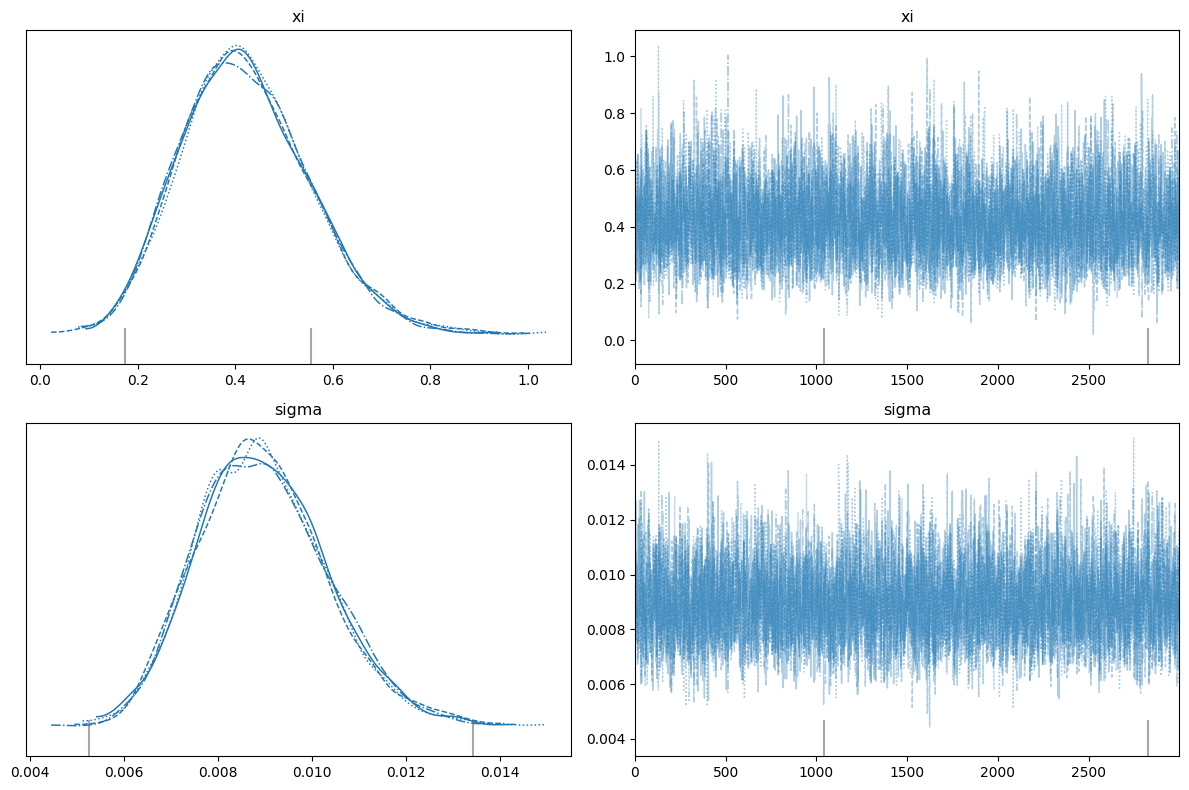

In [172]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
az.plot_trace(trace, axes=axes)
plt.tight_layout()
plt.show()

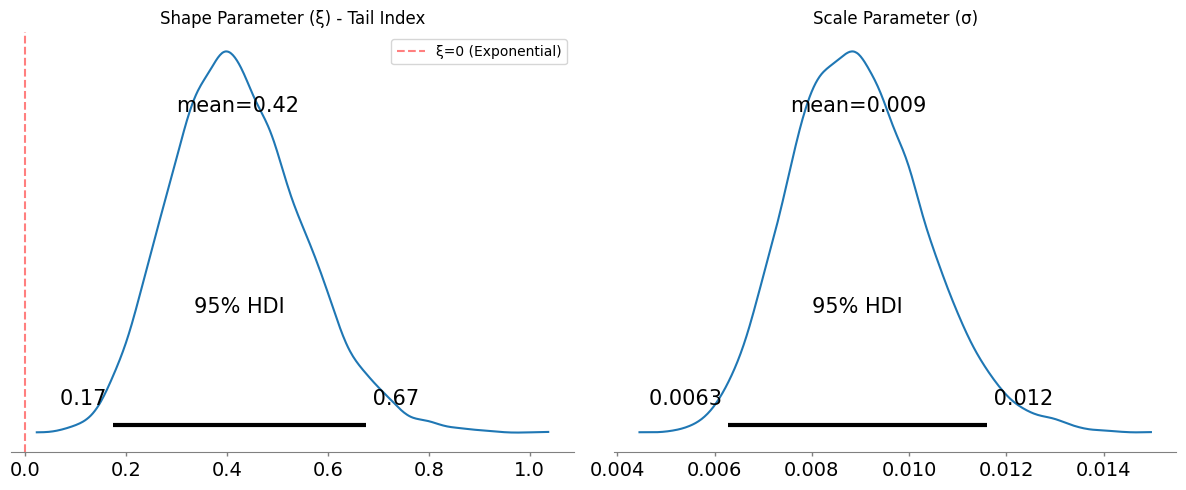

In [173]:
# Posterior distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
az.plot_posterior(trace, var_names=['xi'], hdi_prob=0.95, ax=axes[0], point_estimate='mean')
axes[0].set_title('Shape Parameter (ξ) - Tail Index')
axes[0].axvline(0, color='red', linestyle='--', alpha=0.5, label='ξ=0 (Exponential)')
axes[0].legend()

az.plot_posterior(trace, var_names=['sigma'], hdi_prob=0.95, ax=axes[1], point_estimate='mean')
axes[1].set_title('Scale Parameter (σ)')

plt.tight_layout()
plt.show()

In [174]:
# Step 3: Calculate risk metrics
def calculate_risk_metrics(trace, threshold, exceedance_rate, confidence_levels):
    """Calculate VaR and Expected Shortfall with uncertainty"""
    xi_samples = trace.posterior['xi'].values.flatten()
    sigma_samples = trace.posterior['sigma'].values.flatten()
    
    results = {}
    for cl in confidence_levels:
        # VaR using GPD formula
        var_quantile = threshold + (sigma_samples / xi_samples) * (
            ((1 - cl) / exceedance_rate) ** (-xi_samples) - 1
        )
        
        # Expected Shortfall (Conditional VaR)
        es_quantile = (var_quantile + sigma_samples - xi_samples * threshold) / (1 - xi_samples)
        
        results[f'VaR_{int(cl*1000)}'] = {
            'mean': float(np.mean(var_quantile)),
            'median': float(np.median(var_quantile)),
            'std': float(np.std(var_quantile)),
            'hdi_2.5': float(np.percentile(var_quantile, 2.5)),
            'hdi_97.5': float(np.percentile(var_quantile, 97.5))
        }
        
        results[f'ES_{int(cl*1000)}'] = {
            'mean': float(np.mean(es_quantile)),
            'median': float(np.median(es_quantile)),
            'std': float(np.std(es_quantile)),
            'hdi_2.5': float(np.percentile(es_quantile, 2.5)),
            'hdi_97.5': float(np.percentile(es_quantile, 97.5))
        }
    
    return results

In [175]:
# Calculate metrics for high confidence levels
confidence_levels = [0.95, 0.99, 0.995, 0.999]
exceedance_rate = len(exceedances) / len(losses)
risk_metrics = calculate_risk_metrics(trace, threshold, exceedance_rate, confidence_levels)

print("\n" + "="*50)
print("RISK METRICS WITH UNCERTAINTY")
print("="*50)

for cl in confidence_levels:
    var_key = f'VaR_{int(cl*1000)}'
    es_key = f'ES_{int(cl*1000)}'
    print(f"\n{cl*100:.1f}% Confidence Level:")
    print(f"  VaR: {risk_metrics[var_key]['mean']:.6f} "
          f"(95% HDI: {risk_metrics[var_key]['hdi_2.5']:.6f} - {risk_metrics[var_key]['hdi_97.5']:.6f})")
    print(f"  ES:  {risk_metrics[es_key]['mean']:.6f} "
          f"(95% HDI: {risk_metrics[es_key]['hdi_2.5']:.6f} - {risk_metrics[es_key]['hdi_97.5']:.6f})")

# Compare with empirical quantiles
print("\n" + "="*50)
print("COMPARISON WITH EMPIRICAL QUANTILES")
print("="*50)

for cl in confidence_levels:
    empirical_quantile = np.percentile(losses, cl * 100)
    var_model = risk_metrics[f'VaR_{int(cl*1000)}']['mean']
    print(f"{cl*100:.1f}% Quantile:")
    print(f"  Empirical: {empirical_quantile:.6f}")
    print(f"  Model VaR: {var_model:.6f}")
    print(f"  Difference: {(var_model - empirical_quantile):.6f}")



RISK METRICS WITH UNCERTAINTY

95.0% Confidence Level:
  VaR: 0.024916 (95% HDI: 0.023234 - 0.026281)
  ES:  0.037584 (95% HDI: 0.035062 - 0.043028)

99.0% Confidence Level:
  VaR: 0.041283 (95% HDI: 0.038667 - 0.044333)
  ES:  0.067338 (95% HDI: 0.055423 - 0.093721)

99.5% Confidence Level:
  VaR: 0.052567 (95% HDI: 0.047644 - 0.058789)
  ES:  0.088676 (95% HDI: 0.067137 - 0.139728)

99.9% Confidence Level:
  VaR: 0.097106 (95% HDI: 0.075922 - 0.134326)
  ES:  0.177079 (95% HDI: 0.101925 - 0.384407)

COMPARISON WITH EMPIRICAL QUANTILES
95.0% Quantile:
  Empirical: 0.023800
  Model VaR: 0.024916
  Difference: 0.001117
99.0% Quantile:
  Empirical: 0.042388
  Model VaR: 0.041283
  Difference: -0.001106
99.5% Quantile:
  Empirical: 0.051888
  Model VaR: 0.052567
  Difference: 0.000679
99.9% Quantile:
  Empirical: 0.088535
  Model VaR: 0.097106
  Difference: 0.008570


In [176]:

# Step 4: Model diagnostics
print("\n" + "="*50)
print("MODEL DIAGNOSTICS")
print("="*50)


MODEL DIAGNOSTICS


In [177]:
# Plot QQ plot
xi_mean = float(trace.posterior['xi'].mean().values)
sigma_mean = float(trace.posterior['sigma'].mean().values)

In [178]:
# Theoretical quantiles from fitted GPD
n_exceed = len(exceedances)
theoretical_quantiles = np.zeros(n_exceed)
for i in range(n_exceed):
    p = (i + 1) / (n_exceed + 1)
    if np.abs(xi_mean) < 1e-10:
        theoretical_quantiles[i] = -sigma_mean * np.log(1 - p)
    else:
        theoretical_quantiles[i] = (sigma_mean / xi_mean) * ((1 - p) ** (-xi_mean) - 1)

plt.figure(figsize=(10, 8))

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

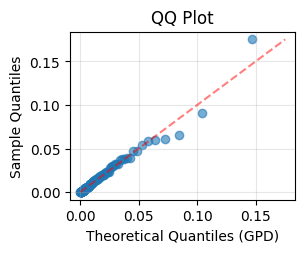

In [179]:
# QQ plot
plt.subplot(2, 2, 1)
plt.scatter(theoretical_quantiles, np.sort(exceedances), alpha=0.6)
plt.plot([0, max(exceedances)], [0, max(exceedances)], 'r--', alpha=0.5)
plt.xlabel('Theoretical Quantiles (GPD)')
plt.ylabel('Sample Quantiles')
plt.title('QQ Plot')
plt.grid(True, alpha=0.3)


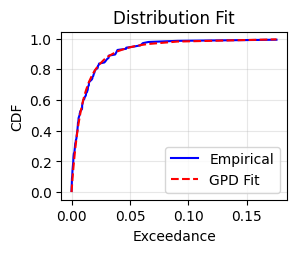

In [180]:
# Excess distribution plot
plt.subplot(2, 2, 2)
sorted_exceedances = np.sort(exceedances)
ecdf_exceed = np.arange(1, len(sorted_exceedances) + 1) / (len(sorted_exceedances) + 1)
theoretical_cdf = 1 - (1 + xi_mean * sorted_exceedances / sigma_mean) ** (-1/xi_mean)
plt.plot(sorted_exceedances, ecdf_exceed, 'b-', label='Empirical')
plt.plot(sorted_exceedances, theoretical_cdf, 'r--', label='GPD Fit')
plt.xlabel('Exceedance')
plt.ylabel('CDF')
plt.title('Distribution Fit')
plt.legend()
plt.grid(True, alpha=0.3)

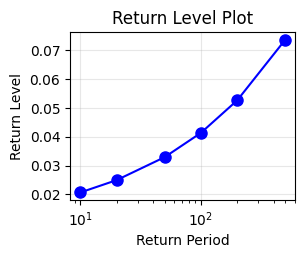

In [181]:
# Return level plot
plt.subplot(2, 2, 3)
return_periods = np.array([10, 20, 50, 100, 200, 500])
return_levels = threshold + (sigma_mean / xi_mean) * (
    (return_periods * exceedance_rate) ** xi_mean - 1
)
plt.plot(return_periods, return_levels, 'bo-', markersize=8)
plt.xlabel('Return Period')
plt.ylabel('Return Level')
plt.title('Return Level Plot')
plt.xscale('log')
plt.grid(True, alpha=0.3)

/tmp/ipykernel_3995/3980662342.py:5: RuntimeWarning: invalid value encountered in power
  model_survival = exceedance_rate * (1 + xi_mean * (sorted_losses - threshold) / sigma_mean) ** (-1/xi_mean)


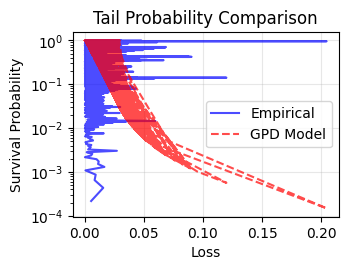

In [182]:
# Diagnostic: Tail probability
plt.subplot(2, 2, 4)
sorted_losses = np.sort(losses)
empirical_survival = 1 - np.arange(1, len(sorted_losses) + 1) / (len(sorted_losses) + 1)
model_survival = exceedance_rate * (1 + xi_mean * (sorted_losses - threshold) / sigma_mean) ** (-1/xi_mean)
model_survival[sorted_losses < threshold] = 1

plt.plot(sorted_losses, empirical_survival, 'b-', label='Empirical', alpha=0.7)
plt.plot(sorted_losses, model_survival, 'r--', label='GPD Model', alpha=0.7)
plt.xlabel('Loss')
plt.ylabel('Survival Probability')
plt.yscale('log')
plt.title('Tail Probability Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [183]:
print("\n" + "="*50)
print("INTERPRETATION")
print("="*50)

xi_mean_val = float(trace.posterior['xi'].mean().values)
if xi_mean_val > 0:
    print(f"ξ = {xi_mean_val:.4f} > 0: The distribution has heavy tails.")
    print(f"This means extreme losses are more likely than in a normal distribution.")
    print(f"The tail decays like a power law: P(X > x) ~ x^(-1/ξ) for large x.")
elif xi_mean_val < 0:
    print(f"ξ = {xi_mean_val:.4f} < 0: The distribution has a finite upper bound.")
    print(f"The maximum possible loss is: {-sigma_mean/xi_mean_val + threshold:.6f}")
else:
    print(f"ξ ≈ 0: The distribution has exponential tails (light tails).")

print(f"\nExpected Shortfall (ES) represents the average loss given that")
print(f"the loss exceeds the VaR threshold. For {confidence_levels[-1]*100:.1f}% VaR,")
print(f"the ES is {risk_metrics[f'ES_{int(confidence_levels[-1]*1000)}']['mean']:.6f}, meaning that")
print(f"in the worst {100-confidence_levels[-1]*100:.1f}% of cases, the average loss is this amount.")



INTERPRETATION
ξ = 0.4212 > 0: The distribution has heavy tails.
This means extreme losses are more likely than in a normal distribution.
The tail decays like a power law: P(X > x) ~ x^(-1/ξ) for large x.

Expected Shortfall (ES) represents the average loss given that
the loss exceeds the VaR threshold. For 99.9% VaR,
the ES is 0.177079, meaning that
in the worst 0.1% of cases, the average loss is this amount.


In [184]:
results_summary = {
    'threshold': float(threshold),
    'n_exceedances': int(len(exceedances)),
    'exceedance_rate': float(exceedance_rate),
    'xi_mean': xi_mean_val,
    'xi_hdi': (float(np.percentile(trace.posterior['xi'].values.flatten(), 2.5)),
               float(np.percentile(trace.posterior['xi'].values.flatten(), 97.5))),
    'sigma_mean': sigma_mean,
    'sigma_hdi': (float(np.percentile(trace.posterior['sigma'].values.flatten(), 2.5)),
                  float(np.percentile(trace.posterior['sigma'].values.flatten(), 97.5))),
    'risk_metrics': risk_metrics
}

print("\nResults have been computed successfully!")
print("\n" + "="*50)
print("RESULTS SUMMARY")
print("="*50)
print(f"Threshold: {results_summary['threshold']:.6f}")
print(f"Exceedances: {results_summary['n_exceedances']}")
print(f"Exceedance rate: {results_summary['exceedance_rate']:.4%}")
print(f"Tail index (ξ): {results_summary['xi_mean']:.4f}")
print(f"Scale (σ): {results_summary['sigma_mean']:.4f}")


Results have been computed successfully!

RESULTS SUMMARY
Threshold: 0.029293
Exceedances: 134
Exceedance rate: 2.9004%
Tail index (ξ): 0.4212
Scale (σ): 0.0090
